In [1]:
import tensorflow as tf # ML library for graphs

c:\users\muhammed buyukkinaci\appdata\local\programs\python\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
#Importing libraries
import cv2                 # image processing
import numpy as np         # mathematical operations
import os                  # working with directories
from random import shuffle # mixing up or currently ordered data that might lead our network astray in training.
from tqdm import tqdm      # a nice progress bar for loops

TRAIN_DIR = 'C:\\Users\\Muhammed Buyukkinaci\\python\\images\\multiclass_classification\\training'
TEST_DIR = 'C:\\Users\\Muhammed Buyukkinaci\\python\\images\\multiclass_classification\\testing'
IMG_SIZE = 80# our images are 80x80x3

In [3]:
os.getcwd()

'C:\\Users\\Muhammed Buyukkinaci\\python\\images\\multiclass_classification'

In [4]:
#Converting the output into one-hot format
def label_img(img):
    word_label = img.split('_')[0]
    if word_label == 'chair': return [1,0,0,0]
    elif word_label == 'kitchen': return [0,1,0,0]
    elif word_label == 'knife': return [0,0,1,0]
    elif word_label == 'saucepan': return [0,0,0,1]

In [5]:
#A function to read training images from folder
def create_train_data():
    training_data = []
    for img in tqdm(os.listdir(TRAIN_DIR)):
        label = label_img(img)
        path = TRAIN_DIR + '\\' + img
        img = cv2.imread(path,1)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        training_data.append([np.array(img),np.array(label)])
    shuffle(training_data)
    np.save('train_data_mc.npy', training_data)
    return training_data

In [6]:
#If you are reading images, make the line below uncomment
#train_data = create_train_data()
#If you are reading .npy file, use the line below.
train_data = np.load('train_data_mc.npy')

In [7]:
#
def process_test_data():
    testing_data = []
    for img in tqdm(os.listdir(TEST_DIR)):
        label = label_img(img)
        path = TEST_DIR + '\\' + img
        img = cv2.imread(path,1)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        testing_data.append([np.array(img),label])       
    shuffle(testing_data)
    np.save('test_data_mc.npy', testing_data)
    return testing_data

In [8]:
#If you are reading images, make the line below uncomment.

#test_data = process_test_data()

#If you are reading .npy file, use the line below.
test_data = np.load('test_data_mc.npy')

In [9]:
#For visualizations
import matplotlib.pyplot as plt

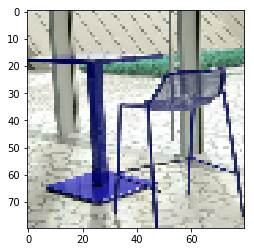

In [10]:
#A CHAIR
plt.imshow(np.array(train_data[180][0]))

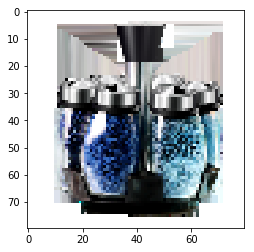

In [11]:
#KITCHEN
plt.imshow(np.array(train_data[100][0]))

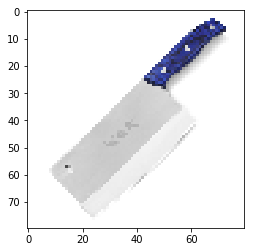

In [12]:
#KNIFE
plt.imshow(np.array(train_data[111][0]))

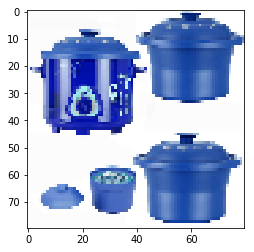

In [13]:
#SAUCEPAN
plt.imshow(np.array(train_data[154][0]))

In [14]:
train = train_data[:4800]
cv = train_data[4800:]

In [15]:
X = np.array([i[0] for i in train]).reshape(-1,IMG_SIZE,IMG_SIZE,3)
Y = np.array([i[1] for i in train])

cv_x = np.array([i[0] for i in cv]).reshape(-1,IMG_SIZE,IMG_SIZE,3)
cv_y = np.array([i[1] for i in cv])

In [16]:
test_x = np.array([i[0] for i in test_data]).reshape(-1,IMG_SIZE,IMG_SIZE,3)
test_y = np.array([i[1] for i in test_data])

In [17]:
X.shape

(4800, 80, 80, 3)

In [18]:
Y[2]

array([0, 0, 0, 1])

In [19]:
cv_x.shape

(400, 80, 80, 3)

In [20]:
test_x.shape

(1267, 80, 80, 3)

In [33]:
#HYPERPARAMETERS
steps = 4800
epochs = 60
step_size = 16
total_batch = int(steps/step_size)
LR = 0.00001

In [34]:
def init_weights(shape):
    init_random_dist = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(init_random_dist)

In [35]:
def init_bias(shape):
    init_bias_vals = tf.constant(0.1, shape=shape)
    return tf.Variable(init_bias_vals)

In [36]:
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

In [37]:
def max_pool_2by2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                          strides=[1, 2, 2, 1], padding='SAME')

In [38]:
def convolutional_layer(input_x, shape):
    W = init_weights(shape)
    b = init_bias([shape[3]])
    return tf.nn.relu(conv2d(input_x, W) + b)

In [39]:
def normal_full_layer(input_layer, size):
    input_size = int(input_layer.get_shape()[1])
    W = init_weights([input_size, size])
    b = init_bias([size])
    return tf.matmul(input_layer, W) + b

In [40]:
X[5].shape

(80, 80, 3)

# GRAPH

In [41]:
tf.reset_default_graph()

In [42]:
x = tf.placeholder(tf.float32,shape=[None,80,80,3])
y_true = tf.placeholder(tf.float32,shape=[None,4])

In [43]:
with tf.name_scope('Model'):
    convo_1 = convolutional_layer(x,shape=[6,6,3,32])
    convo_1_pooling = max_pool_2by2(convo_1)
    convo_2 = convolutional_layer(convo_1_pooling,shape=[6,6,32,64])
    convo_2_pooling = max_pool_2by2(convo_2)
    convo_3 = convolutional_layer(convo_2_pooling,shape=[6,6,64,64])
    convo_3_pooling = max_pool_2by2(convo_3)
    convo_4 = convolutional_layer(convo_3_pooling,shape=[6,6,64,128])
    convo_4_pooling = max_pool_2by2(convo_4)
    convo_2_flat = tf.reshape(convo_4_pooling,[-1,5*5*128])
    
    full_layer_one = tf.nn.relu(normal_full_layer(convo_2_flat,4096))
    hold_prob1 = tf.placeholder(tf.float32)
    full_one_dropout = tf.nn.dropout(full_layer_one,keep_prob=hold_prob1)
    
    full_layer_two = tf.nn.relu(normal_full_layer(full_one_dropout,2048))
    hold_prob2 = tf.placeholder(tf.float32)
    full_two_dropout = tf.nn.dropout(full_layer_two,keep_prob=hold_prob2)
                                     
    full_layer_three = tf.nn.relu(normal_full_layer(full_two_dropout,1024))
    hold_prob3 = tf.placeholder(tf.float32)
    full_three_dropout = tf.nn.dropout(full_layer_three,keep_prob=hold_prob3)
    
    full_layer_four = tf.nn.relu(normal_full_layer(full_three_dropout,512))
    hold_prob4 = tf.placeholder(tf.float32)
    full_four_dropout = tf.nn.dropout(full_layer_four,keep_prob=hold_prob4)
    
    y_pred = normal_full_layer(full_four_dropout,4)

In [44]:
with tf.name_scope('Loss'):
    cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_true,logits=y_pred))

In [45]:
with tf.name_scope('ADAM'):
    train = tf.train.AdamOptimizer(learning_rate=LR).minimize(cross_entropy)

In [46]:
with tf.name_scope('Accuracy'):
    matches = tf.equal(tf.argmax(y_pred,1),tf.argmax(y_true,1))
    acc = tf.reduce_mean(tf.cast(matches,tf.float32))

In [47]:
init = tf.global_variables_initializer()

In [48]:
tf.summary.scalar("loss", cross_entropy)
tf.summary.scalar("accuracy", acc)
merged_summary_op = tf.summary.merge_all()

In [49]:
acc_list = []
logloss_list = []
acc_train = []

In [50]:
saver = tf.train.Saver()

In [51]:
%%time
config = tf.ConfigProto(allow_soft_placement=True)
config.gpu_options.allow_growth = True
config.gpu_options.allocator_type = 'BFC'
with tf.Session(config=config) as sess:
    sess.run(init)
    summary_writer = tf.summary.FileWriter(TRAIN_DIR, graph=tf.get_default_graph())
    for i in range(epochs):
        for j in range(0,steps,step_size):            
            _ , c , summary,d = sess.run([train,cross_entropy,merged_summary_op,acc],feed_dict={x:X[j:j+step_size] , y_true:Y[j:j+step_size] ,hold_prob1:0.5,hold_prob2:0.5,hold_prob3:0.5,hold_prob4:0.5})
            summary_writer.add_summary(summary, i * total_batch + j)
            acc_train.append(d)
            mean_of_ll = sess.run(cross_entropy,feed_dict={x:cv_x,y_true:cv_y ,hold_prob1:1.0,hold_prob2:1.0,hold_prob3:1.0,hold_prob4:1.0})
            mean_of_acc = sess.run(acc,feed_dict={x:cv_x ,y_true:cv_y ,hold_prob1:1.0,hold_prob2:1.0,hold_prob3:1.0,hold_prob4:1.0})
            logloss_list.append(mean_of_ll)
            acc_list.append(mean_of_acc)
        print(i,mean_of_ll,mean_of_acc)
    saver.save(sess, os.getcwd()+"\\CNN_MC.ckpt")
    print("test accuracy = ",np.mean([sess.run(acc,feed_dict={x:test_x[:400],y_true:test_y[:400] ,hold_prob1:1.0,hold_prob2:1.0,hold_prob3:1.0,hold_prob4:1.0}),sess.run(acc,feed_dict={x:test_x[400:800],y_true:test_y[400:800] ,hold_prob1:1.0,hold_prob2:1.0,hold_prob3:1.0,hold_prob4:1.0}),sess.run(acc,feed_dict={x:test_x[800:],y_true:test_y[800:] ,hold_prob1:1.0,hold_prob2:1.0,hold_prob3:1.0,hold_prob4:1.0})]))   
    print("cross_entropy loss = ",np.mean([sess.run(cross_entropy,feed_dict={x:test_x[:400],y_true:test_y[:400] ,hold_prob1:1.0,hold_prob2:1.0,hold_prob3:1.0,hold_prob4:1.0}),sess.run(cross_entropy,feed_dict={x:test_x[400:800],y_true:test_y[400:800] ,hold_prob1:1.0,hold_prob2:1.0,hold_prob3:1.0,hold_prob4:1.0}),sess.run(cross_entropy,feed_dict={x:test_x[800:],y_true:test_y[800:] ,hold_prob1:1.0,hold_prob2:1.0,hold_prob3:1.0,hold_prob4:1.0})]))   

0 85719.37 0.32
1 33517.863 0.3675
2 20160.877 0.4225
3 13489.607 0.4725
4 8454.184 0.53
5 6947.601 0.5375
6 5610.687 0.5425
7 4604.3633 0.58
8 3817.8535 0.56
9 3250.721 0.5875
10 2903.8716 0.5775
11 2539.5173 0.5925
12 2230.232 0.595
13 2129.1494 0.6025
14 2029.1711 0.6025
15 1922.1516 0.5975
16 1740.3193 0.6
17 1604.364 0.61
18 1442.7289 0.625
19 1341.4667 0.605
20 1283.664 0.615
21 1129.2913 0.615
22 1066.8564 0.61
23 966.67163 0.625
24 937.3264 0.61
25 832.85864 0.6225
26 802.7457 0.63
27 725.6311 0.6275
28 660.98755 0.61
29 629.6267 0.62
30 613.3628 0.63
31 608.3986 0.6525
32 545.4546 0.6275
33 514.37756 0.6275
34 497.07196 0.62
35 449.03693 0.615
36 435.7846 0.6325
37 431.58218 0.64
38 391.89514 0.6325
39 365.53796 0.65
40 358.36426 0.635
41 329.56345 0.65
42 331.95007 0.6325
43 327.5453 0.62
44 307.39114 0.6425
45 312.42316 0.635
46 284.61823 0.6275
47 279.4325 0.6425
48 255.56476 0.645
49 256.77472 0.63
50 234.81563 0.6325
51 215.44609 0.655
52 196.39459 0.6475
53 199.85449 0.6

In [52]:
import pandas as pd

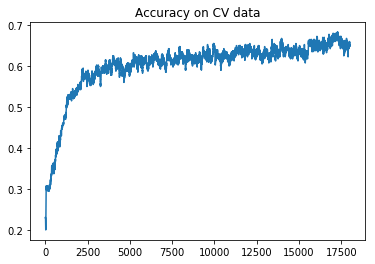

In [53]:
pd.Series(acc_list).plot(kind='line',title='Accuracy on CV data')

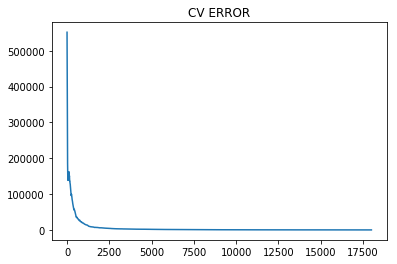

In [54]:
pd.Series(logloss_list).plot(kind='line',title='CV ERROR')